# Old Rating

A previous version of this project was focused on delivering ratings as rapidly as possible.  The result was a high number of low-quality ratings that I will be using as a rough guide early on.

In [1]:
from bmb                        import ProcessingDB
from bmb.source.standard_import import *
from tqdm.notebook              import tqdm
from matplotlib                 import pyplot       as plt
import numpy as np
processing = ProcessingDB()

## Rating 4 - Already Seen

The easiest rating to deal with is **4 - Movies I've Already Seen**.  Each film with this rating should have its data downloaded and be tagged for the data warehouse.

In [13]:
already_seen = processing.select( "title", "year", "OldRating", rating=4)

In [14]:
for title, year in tqdm(already_seen):
    film_id = processing.Film( title, year)
    processing.lookup_film_info( film_id)
    
    if processing.select_one( 'status', 'Film', id=film_id) == processing.Status( 'basic info'):
        processing.set( "UPDATE Film SET status=? WHERE id=?", processing.Status( 'warehouse'), film_id)

  0%|          | 0/475 [00:00<?, ?it/s]

### Visualization

Some of the films will not be marked for the warehouse just yet - some should have had a "foreign language hold" placed on them.  Let's create a pie chart to see how the import did overall.

The Python SQLite `WHERE ... IN` clause is a little weird, so I'm taking a more slow (but clear) one-item-at-a-time approach.

In [15]:
def status_count( title_year_tuples):
    status_count = defaultdict( lambda: 0)
    for film_id in (processing.Film( *ty) for ty in title_year_tuples):
        status_count[
            processing.select_one(
                'text',
                'Status',
                id=processing.select_one( 'status', 'Film', id=film_id)
            )
        ] += 1
    return status_count

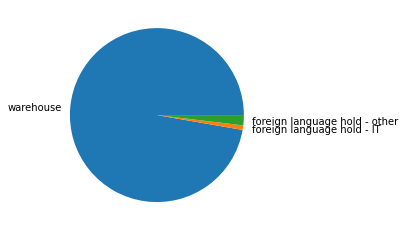

warehouse - 462
foreign language hold - IT - 4
foreign language hold - other - 9


In [16]:
already_seen_status = status_count(already_seen).items()

labels, values = zip( *already_seen_status)
plt.pie( values, labels=labels)
plt.show()

print( "\n".join((f"{label} - {value}" for label, value in already_seen_status )))

# Rating 1 - Reject

Another rating which should be a strong signal is **1 - Manually Rejected**.  The old ratings are not high-quality enought to be trusted on their own, but they should indicate some possibilities.

In [6]:
rejected = processing.select( "title", "year", "OldRating", rating=1)
print( f"{len( rejected)} films were rejected")

3027 films were rejected


In order to look for similarities among these films, we need some basic information:

In [7]:
for title, year in tqdm(rejected):
    film_id = processing.Film( title, year)
    processing.lookup_film_info( film_id)

  0%|          | 0/3027 [00:00<?, ?it/s]

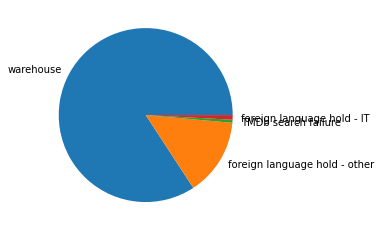

warehouse - 2549
foreign language hold - other - 435
TMDb search failure - 17
foreign language hold - IT - 26


In [8]:
labels, values = zip( *status_count(rejected).items())
plt.pie( values, labels=labels)
plt.show()

print( "\n".join((f"{label} - {value}" for label, value in zip( labels, values) )))

One way to use this data without putting too much trust in it is to look for genre combinations that I have rejected often.  This should indicate which automated filters I should begin to develop.

A heatmap will be used to see which genre pairs were most often rejected.

In [9]:
FILM_ID_TO_GENRES = """
SELECT g.text 
FROM FilmGenre fg JOIN Genre g ON fg.genre = g.id
WHERE fg.film=?
"""

def genre_pairs_count( titleyears):
    film_ids = *( processing.Film( *ty) for ty in titleyears),
    
    genre_combinations = [ 
        processing.get( FILM_ID_TO_GENRES, film_id) 
        for film_id in film_ids ]
    
    pair_count = defaultdict( lambda: defaultdict( lambda: 0))
    for genres in genre_combinations:
        if len( genres) == 1:
            genre = genres[0]
            pair_count[ genre][ genre] += 1

        else:
            for g, genre in enumerate( genres):
                for i in range( g):
                    pair_count[ genres[i]][ genre] += 1
                    pair_count[ genre][ genres[i]] += 1
    return pair_count

                    
pair_count    = genre_pairs_count( rejected)                    
genre_order    = sorted( pair_count.keys())
heatmap_values = [
    [pair_count[ inner_genre][ outer_genre]
        for inner_genre in genre_order ]
        for outer_genre in genre_order
]

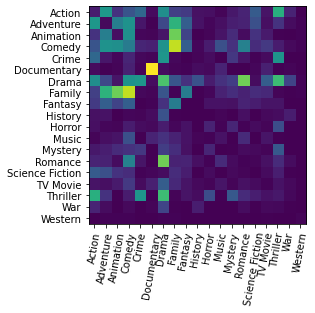

In [10]:
plt.xticks(ticks=np.arange( len( genre_order)), labels=genre_order, rotation= 80)
plt.yticks(ticks=np.arange( len( genre_order)), labels=genre_order)

plt.imshow( heatmap_values)
plt.show()

_Brighter squres indicaed more commonly-rejected combinations._

This heatmap both indicates some avenues for further exploration and shows the limitations of this method.
* __Look into building filters for:__ Family, Drama, Thriller.
* _The previous version of this project served a lot of \<STREAMER\> Original Series_, including a large proportion of documentaries on stuff that I don't care about.  __The Documentary Bright Spot indicates a data artifact more than a true preference against the genre.__
* _We need additional information about the relative frequency of each combination._ I rejected several Action-Adventure films, but very few pure-action or pure-adventure films.  This probably does indicates that the pure genres are very uncommon, rather than an affinity for them.  __Action Item: find the average genre and decade composition across the entire database so there is a point of comparison for subsets of films._
